In [26]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from ZW_utils import std_classes
from ZW_model import GPT
from ZW_Opt import *
from split_functions import bound_creation, layout_to_string_single_1d,equipments_to_strings
from thermo_validity import *
from tqdm.notebook import trange

classes = std_classes
layouts = np.load("M2_data_300_8_augmented_layouts.npy", allow_pickle=True)
results = np.load("M2_data_300_8_augmented_results.npy", allow_pickle=True)
print(len(layouts), len(results))
layouts = equipments_to_strings(layouts, classes)
results = 1 - (results - 125) / 175
indices = np.argsort(results)
sorted_results = np.array(results)[indices]
sorted_layouts = np.array(layouts)[indices]
unique, indices = np.unique(sorted_layouts, return_index=True)
unique_results = sorted_results[indices]
unique_layouts = sorted_layouts[indices]
print(len(unique_layouts), len(unique_results))
layouts = unique_layouts.tolist()
results = unique_results
new_layouts = []
new_results = []

68026 68026
67345 67345


In [1]:
def evaluation(layout):
    # 1. One hot encoding from integer
    layout = layout.astype(int)
    stringlist = [
        layout_to_string_single_1d(layout),
    ]
    valid_string = validity(stringlist)
    if len(valid_string) == 0:
        return -1
    if valid_string[0] in new_layouts:
        return new_results[new_layouts.index(valid_string[0])]
    if valid_string[0] in layouts:
        return results[layouts.index(valid_string[0])]
    ohe = np.zeros((len(layout), len(classes)))
    for i, l in enumerate(layout):
        ohe[i, l] = 1
    equipment, bounds, x, splitter = bound_creation(ohe)
    swarmsize_factor = 7
    nv = len(bounds)
    particle_size = swarmsize_factor * nv
    if 5 in equipment:
        particle_size += -1 * swarmsize_factor
    if 9 in equipment:
        particle_size += -2 * swarmsize_factor
    iterations = 30
    try:
        a = PSO(objective_function, bounds, particle_size, iterations, nv, equipment)
        if a.result < 300:
            # standardization between 125 and 300 to 1 and 0
            value = 1 - (a.result - 125) / 175
            new_layouts.append(valid_string[0])
            new_results.append(value)
            print(value, valid_string[0])
        else:
            value = -0.25
    except:
        value = -0.5
    return value


class Flowsheet:
    def __init__(self) -> None:
        self.column_count = 23
        self.action_size = 12

    def __repr__(self):
        return "Flowsheet"

    def get_initial_state(self):
        blank_state = np.ones(self.column_count) * -1
        blank_state[0] = 0
        return blank_state

    def get_next_state(self, state, action):
        column = np.where(state == -1)[0][0]
        state[column] = action
        return state

    def get_valid_moves(self, state):
        return state.reshape(-1) == -1

    def check_win(self, state, action):
        if action == 11:
            return True
        return False

    def get_value_and_terminated(self, state, action):
        if self.check_win(state, action):
            value = evaluation(self.get_encoded_state(state))
            return value, True
        if np.sum(self.get_valid_moves(state)) == 0:
            return -1, True
        return -1, False

    def get_encoded_state(self, state):
        try:
            column = np.where(state == -1)[0][0]
        except:
            column = self.column_count
        encoded_state = state[:column]
        return encoded_state

In [ ]:
class Node:
    def __init__(self,game,args,state,parent=None,action_taken=None,prior = 0,visit_count=0):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior

        self.children = []

        self.visit_count = visit_count
        self.value_sum = 0
    
    def is_fully_expanded(self):
        return len(self.children) > 0

    def select(self):
        best_child = None
        best_ucb = -np.inf
        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_ucb = ucb
                best_child = child
        return best_child
    
    def get_ucb(self,child):
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = ((child.value_sum / child.visit_count)+1)/2
        return q_value + self.args["C"] * (np.sqrt(self.visit_count) / (child.visit_count+1))*child.prior
    def expand(self,policy):
        for action, prob in enumerate(policy):
            if prob > 0:
                child_state = self.state.copy()
                child_state = self.game.get_next_state(child_state,action)
                child = Node(self.game,self.args,child_state,self,action,prob)
                self.children.append(child)

    def backpropagate(self,value):
        self.value_sum += value
        self.visit_count += 1
        if self.parent != None:
            self.parent.backpropagate(value)

class MCTS:
    def __init__(self,game,args,model):
        self.game = game
        self.args = args
        self.model = model
        self.valid_moves = np.ones(self.game.action_size)
        self.valid_moves[0],self.valid_moves[6],self.valid_moves[8],self.valid_moves[10] = 0,0,0,0

    @torch.no_grad()
    def search(self,state):
        root = Node(self.game,self.args,state,visit_count=1)
        input = torch.tensor(self.game.get_encoded_state(state),dtype=torch.long).unsqueeze(0)
        lengths = torch.tensor([x for x in map(len, input)])
        policy,_ = self.model(
            input,lengths
        )
        policy = torch.softmax(policy,axis=-1).squeeze(0).detach().numpy()
        
        policy = (1-self.args["dirichlet_epsilon"])*policy + self.args["dirichlet_epsilon"]\
            *np.random.dirichlet([self.args["dirichlet_alpha"]]*self.game.action_size)

        policy*=self.valid_moves
        policy /= np.sum(policy)
        root.expand(policy)
        for search in range(self.args["num_searches"]):
            node = root
            while node.is_fully_expanded():
                node = node.select()
            value,is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)

            if not is_terminal:
                input = torch.tensor(self.game.get_encoded_state(node.state),dtype=torch.long).unsqueeze(0)
                lengths = torch.tensor([x for x in map(len, input)])
                policy,value = self.model(
                    input,lengths
                )
                policy = torch.softmax(policy,axis=-1).squeeze(0).detach().numpy()
                policy*=self.valid_moves
                policy /= np.sum(policy)

                value = value.item()
                node.expand(policy)
            node.backpropagate(value)
        
        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
        return action_probs

In [29]:
class Alphazero:
    def __init__(self,model,optimizer,game,args):
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.mcts = MCTS(game,args,model)

    def selfPlay(self):
        memory = []
        state = self.game.get_initial_state()

        while True:
            action_probs = self.mcts.search(state)
            memory.append((state,action_probs))
            #Temperature lim 0 exploiation, lim inf exploration (more randomness)
            temperature_action_probs = action_probs**(1/self.args["temperature"])
            temperature_action_probs /= np.sum(temperature_action_probs)

            action = np.random.choice(self.game.action_size,p=temperature_action_probs)
            state = self.game.get_next_state(state,action)
            value,is_terminal = self.game.get_value_and_terminated(state,action)
            if is_terminal:
                returnMemory = []
                for hist_neutral_state,hist_action_probs in memory:
                    hist_outcome = value 
                    returnMemory.append((
                        self.game.get_encoded_state(hist_neutral_state),
                        hist_action_probs,
                        hist_outcome
                    ))
                return returnMemory


    def train(self,memory):
        random.shuffle(memory)
        for batchIdx in range(0,len(memory),self.args['batch_size']):
            sample = memory[batchIdx:min(len(memory)-1,batchIdx+self.args['batch_size'])]
            states,policy_targets,value_targets = zip(*sample)
            #padding necessicity
            lengths = torch.tensor([len(x) for x in states])
            max_length = max(lengths)
            #padding to the maximum length
            states = [x.tolist()+[12]*(max_length-len(x)) for x in states]
            states,policy_targets,value_targets = np.array(states),np.array(policy_targets),np.array(value_targets).reshape(-1,1)            
            states = torch.tensor(states).long()
            policy_targets = torch.tensor(policy_targets).float()
            value_targets = torch.tensor(value_targets).float()
            
            out_policy, out_value = self.model(states,lengths)

            policy_loss = F.cross_entropy(out_policy,policy_targets)
            value_loss = F.mse_loss(out_value,value_targets)
            loss = policy_loss + value_loss

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            

    def learn(self):
        for iteration in range(self.args["num_iterations"]):
            memory = []

            for selfPlay_iteration in trange(self.args["num_selfPlay_iterations"]):
                memory += self.selfPlay()
            self.model.train()
            for epoch in trange(self.args["num_epochs"]):
                self.train(memory)
            save_path = self.args["save_path"]
            torch.save(self.model.state_dict(),f"{save_path}/model_{iteration}_{self.game}.pt")
            torch.save(self.optimizer.state_dict(),f"{save_path}/optimizer_{iteration}_{self.game}.pt")

In [30]:
class LSTM_packed(nn.Module):
    def __init__(self, embd_size,hidden_size):
        super(LSTM_packed, self).__init__()
        self.embedding = nn.Embedding(13, embd_size)
        self.lstm = nn.LSTM(embd_size, hidden_size, num_layers=2, batch_first=True, dropout=0.1)
        self.valuehead = nn.Linear(hidden_size, 1)
        self.policyhead = nn.Linear(hidden_size, 12)
    def forward(self, x, lengths):
        x = self.embedding(x.long())
        x = nn.utils.rnn.pack_padded_sequence(
            x, lengths, batch_first=True, enforce_sorted=False
        )
        output, (hidden, _) = self.lstm(x)
        value = self.valuehead(hidden[-1])
        policy = self.policyhead(hidden[-1])
        return policy, value

[ 0.  1.  2.  3.  4. 11. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1.]
[ 0.  1.  2.  3.  4. 11.]
-0.02481631562113762


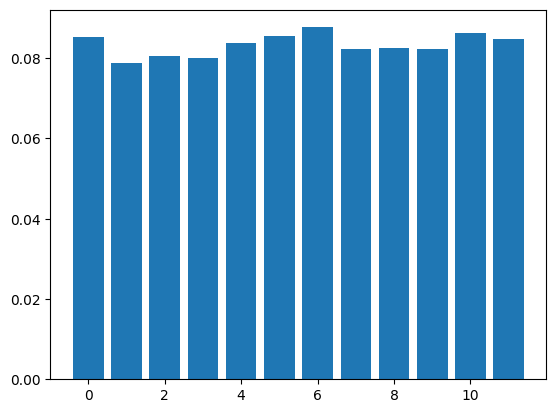

In [31]:
import matplotlib.pyplot as plt
ttt = Flowsheet()
state = ttt.get_initial_state()
state = ttt.get_next_state(state,1)
state = ttt.get_next_state(state,2)
state = ttt.get_next_state(state,3)
state = ttt.get_next_state(state,4)
state = ttt.get_next_state(state,11)
print(state)

encoded_state = ttt.get_encoded_state(state)
print(encoded_state)
tensor_state = torch.tensor(encoded_state).unsqueeze(0)
lengths = torch.tensor([x for x in map(len, tensor_state)])
#untrained model
model = LSTM_packed(64,256)
# #trained model
# model.load_state_dict(torch.load('model_2.pt'))
model.eval()
policy, value = model(tensor_state,lengths)
value = value.item()
policy = torch.softmax(policy,axis=1).squeeze(0).detach().numpy()
print(value)
plt.bar(range(ttt.action_size),policy)
plt.show()

In [32]:
game = Flowsheet()
model = LSTM_packed(64,256)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4)
args = {
    "C":2,
    "num_searches":100,
    "num_iterations":6,
    "num_selfPlay_iterations":500,
    "num_epochs":30,
    "batch_size":100,
    "temperature":1,
    "dirichlet_epsilon":0.1,
    "dirichlet_alpha":0.3,
    "save_path":"./RL/policy_value_model_trials"
}
alphazero = Alphazero(model,optimizer,game,args)
alphazero.learn()

  0%|          | 0/500 [00:00<?, ?it/s]

0.806575038489644 GCHTAE
0.7053551270926197 GACHTE
0.7111585440164447 GACACAHTE
0.6676225580573714 GACACAHTACE
0.7890828084358902 GTCACHE
0.7408445226091437 GTHCTACE
0.645114510521313 GTHCTACAE
0.7185150863115103 GTaHTCa1A1C-1HCAE
0.3632627909209486 GTaHTCa1A1C-1HCTAE
0.8065773019702467 GHTACE
0.7610518182038397 GHTATCE
0.8065693457363965 GTACHE
0.5122180206386161 GCHaHACTaTE
0.6802753339067916 GTCACACHE


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

0.5235320746272839 GHATCHTE
0.7466672951469439 GHATCHTHTE
0.7073676400409311 GTACATACHE
0.7068849322058839 GTACATCAHE
0.6989699180904734 GTACATACAHE
0.6504910912851065 GTACATACATHE
0.742041732217191 GTACATACACHE
0.6456069999651457 GTACATACAHCE
0.8063221114988179 GHTACTE
0.7694562955223944 GCaTHaTAE


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

0.7169106823068309 GAHTACE
0.7264549665411203 GTAHTACE
0.6087662257652953 GTATHTCACE
0.7398547418863413 GHTCACE
0.7070406461173626 GHTATCTAE
0.8128094890337793 GHTACTHCE
0.26106965113913505 GHTATCHAE
0.7258384943607985 GHTATCAE
0.7851207315229317 GHTATCHCE
0.6525596981862098 GHTATCTCE
0.8026500039280825 GHTATCTE
0.7880987551649414 GHTATCACE
0.684692734836238 GTCHTAE
0.806573411464015 GTACTHE
0.7637300844144899 GTACTHCE
0.8042288516364375 GTACHCE
0.7297521836994838 GTACAHE
0.8065612152503772 GTHTACE
0.7922702912711163 GTATATCHE
0.7364335414177976 GTATATCHCE
0.7210284514318568 GHTACHCE
0.8260691621880608 GHTACHTCE
0.826337439250223 GHTACHTE
0.2665028278724929 GHTACHAE
0.5001068870667492 GHTACHACE
0.8262956760330593 GTACHTHE
0.739447524739014 GTACHTAE
0.6996761877592033 GTACAHCE
0.8036837410194343 GTATCHE
0.7969622247931943 GTATCHTCE
0.2665031815851585 GTACHAHE
0.5440568000341851 GTACHACHE
0.7483724742482196 GH1TA1ACH-1E
0.734111007708071 GH1TA1ACH-1AE
0.7831465264416956 GHTATCACTE
0.7077

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

0.7292706536238538 GTACTAHE
0.8229620815498111 GATCHCHTE
0.6000749348991381 GHTACAE
0.6938936526500059 GHTACATE
0.7627190968962699 GHTACACE
0.43775030925082237 GaTCAHaACE
0.7045913613443486 GTAHTACAE
0.5959228871806974 GCHTCAE
0.7233531475280799 GTCAHTAE
0.8022359638273256 GTHCTATCE
0.6822649145696271 GTHCTATCAE
0.7308133975276832 GTHCTATCAHE
0.7693035516513328 GTCATCHTAE
0.7742218808460918 GTCATCHTCE
0.5770872822424951 GAHTCTACE
0.7057473761582294 GAHTCACE
0.7258288612779051 GATCAHTE
0.7143815258692642 GTHTACAE
0.728582303413557 GHTACATHCE
0.7410286230958847 GHTACATHTE
0.6725888119724319 GTCATCTHE
0.8063487987890884 GCTACHE
0.6990525515673637 GCTACAHE
0.7275326930038435 GTCTATCHE
0.5317245575527529 GTCACHCE
0.576954356439261 GTCACHCHE
0.7002219378661847 GTCATHCTAE
0.6648269889883693 GHCTACE
0.2043404806832687 GTCAHTHAE
0.39653454422335266 GTCAHTHACE


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

0.6381804232191267 GCTATACHE
0.7282073514483167 GCTATACHTE
0.6665680526212119 GTACTATHE
0.708094774974611 GTACTATAHE
0.6037243202837289 GTACTATACHCE
0.7197459826602626 GTACTATACHE
0.6996641623531012 GTACTAHCE
0.5555917168078742 GTACTAHCHE
0.7658154415648348 GTACTCHE
0.6416576957894259 GTACTCHCE
0.6825359430763076 GTACTCHCHE
0.2098297588567425 GHATAHTACE
0.2664451566673095 GTAHTACHE
0.32531680671121566 GTACTHACHE
0.7217551398837194 GTACTCTHE
0.7331754138564283 GTACTCTHCE
0.7872309807264551 GTACTCTHCHE
0.6887157160847307 GCTATACAHE
0.7046509542781241 GCTACTHE
0.7003264282610813 GCTACTCHE
0.7051144642066107 GCHTATE
0.7515901504321523 GCHTATAE
0.7136996525133793 GTATACTHE
0.6159263174972357 GTATACTAHE
0.0213599060872256 GTATACTACHCE
0.6542236130933266 GTATACTAHCE
0.7169106871484359 GCAHTAE
0.7115157897007702 GCAHTACAE
0.489340777685876 GCTHACHE
0.6930287272267563 GCTAHTAE
0.8252365692187995 GTACTHCHE
0.6003237515745288 GTACTHCHCE
0.41614344977345497 GTACTHCHACHE
0.7084110099117444 GAHTATCE

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

0.8035801339677963 GATCHTE
0.7310771735453752 GATCHTATE
0.5350170732964913 GAHTCATCE
0.5245918783687856 GAHTCATCTE
0.11930044872350531 GAHTCATCHE
0.42656645035866825 GHATCATAHTE
0.6974870144559153 GHATCATAHTHTE
0.445592563122181 GCHTHCAE
0.40968766644620214 GCHTHCATE
0.26046286003349106 GTHCHTHACE
0.5983796248767608 GTCHTCACAE
0.6706383767554088 GTHACHE
0.2662487892207934 GHTACHATE
0.1645014895031438 GTACTHACTHE
0.3829646192861237 GTACTHACTHTCE
0.28910244206585045 GHTCATCTE
0.6469453522815074 GHTCATCTAE
0.7690378796964858 GHTCATCTHTE
0.7606348403313092 GTCHTATCE
0.7416189969334833 GTCHTATAE
0.2621405516708881 GHCAHTACE
0.26650323333887416 GCHAHTAE
0.5027619838332977 GCHCaAaTAE
0.6487657120136487 GHTCACAE
0.5939934881540037 GHTCACATE
0.6996761726211931 GAHCTACE
0.6960928892992201 GAHCTATCE
0.8028077291583869 GCTHTAE
0.5345327870967045 GHATCHCTE
0.6183238038635586 GaHTATCACaHE
0.296097380468173 GTHCHACHE
0.4017523366919421 GTHCHACAHE
0.6858646778601474 GCHTaHCaAE
0.5167534615056638 GCHTa

  0%|          | 0/30 [00:00<?, ?it/s]

In [35]:
game = Flowsheet()
args = {
    "C":2,
    "num_searches":100,
    "num_iterations":6,
    "num_selfPlay_iterations":500,
    "num_epochs":30,
    "batch_size":100,
    "temperature":1,
    "dirichlet_epsilon":0.1,
    "dirichlet_alpha":0.3,
    "save_path":"./RL/policy_value_model_trials"
}
model = LSTM_packed(64,256)
model.state_dict(torch.load('RL/policy_value_model_trials/model_5_Flowsheet.pt'))
model.eval()
mcts = MCTS(game, args,model)
state = game.get_initial_state()
while True:
    mcts_probs = mcts.search(state)
    action = np.argmax(mcts_probs)
        
    state = game.get_next_state(state, action)
    value,is_terminal = game.get_value_and_terminated(state,action)

    if is_terminal:
        print(value, state)
        break

-1 [0. 1. 4. 5. 7. 1. 7. 4. 5. 1. 9. 9. 5. 5. 5. 2. 5. 9. 7. 2. 1. 1. 9.]
